# Finite-Difference Method Solution For The Wave Equation

Computational Physics Project 03 | *Joseph Godoy*

---

**Theory**

The behavior of a transverse disturbance propagating through a string is described by the aptly-named *Wave Equation*, a second-order DE.

$$\dfrac{\partial u^2(x,t)}{\partial x^2}=\dfrac{\rho}{F_t} \dfrac{\partial u^2(x,t)}{\partial t^2}$$


where $F_T$ is the string's tension and $\rho$ is the string's linear density $\frac{M}{L}$. Solving a wave equation is fairly straightforward if you're willing to solve a separable DE. If you're not, no worries: the wave equation can also be solved numerically through the *finite difference method*, a technique that relates derivatives to difference equations.

$$\dfrac{\partial u^2(x,t)}{\partial x^2} \approx \frac{u(x+h,t)-2u(x,t)+u(x-h,t)}{h^2}$$

After massaging the expression, we can obtain an approximate solution form that is useful for computation.

$$u_{m}^{n+1} = 2(1-\beta^2)u_m^n - u_m^{n-1} + \beta^2(u_{m-1}^n+u_{m+1}^n)$$

We can time-evolve this expression and populate arrays with the time steps and displacements it yields.

---

**Computation**

This program is based on (and includes) the work of High Point University's Dr. Aaron Titus, as well as Thomas Boudreaux's animation functions.

In this program we will:

* Animate a string with a travelling Gaussian disturbance and a free right-end

* Find the system's eigenvalues, eigenvectors, and plot its normal modes

* Time-evolve the system under various conditions

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import ode
from mplEasyAnimate import animation
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.linalg import toeplitz
from numpy import linalg as lin
import seaborn
seaborn.set();

/home/joseph/libs/Anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/joseph/libs/Anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/joseph/libs/Anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def wavemotion(u0, u1):
    u2 = 2*(1-b)*u1 - u0                     
    u2[1:-1] += b*( u1[0:-2] + u1[2:] )      
    return u2

def gaussian(x):
    return np.exp(-(x-5)**2)

def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

## Tools for manipulating matrices

def fill_upper(matrix, value):
    for i in range(0,len(matrix)-1,1):
        if i % 2 == 0:
            matrix[i][i+1] = value
        elif i % 2 == 1:
            matrix[i][i+1] = value

def fill_lower(matrix, value):
    for i in range(0,len(matrix)-1,1):
        if i % 2 == 0:
            matrix[i+1][i] = value
        elif i % 2 == 1:
            matrix[i+1][i] = value

def fill_diagonal(matrix, value):
    for i in range(0,len(matrix),1):
        matrix[i][i] = value

def banded_matrix(size, a, b, c, d):
    
    # Main diagonal and unused elements set to 0.
    
    row_one, row_two = [0],[0]

    # Diagonals are filled from the bottom up;
    # The first argument represents the lowest band,
    # The last argument represents the highest band.
    
    row_one.append(b) 
    row_one.append(a) 
    row_two.append(c) 
    row_two.append(d) 
    
    # The rest of the diagonals are filled with zeroes.
    
    for i in range(size-3): 
        row_one.append(0)
        row_two.append(0)

    # The matrix is generated and returned.
    
    return toeplitz(row_one, row_two)

# This function is passed the number of elements in your string, N,
# the length of the string, L, and your time array. It returns 
# the system's eigenvalues and eigenvectors, and plots the normal modes.

def eigenstuff(N, L, ta):
    
    L0 = L
    N = N
    k = 1
    m = 1
    t = 1 
    phi = 1 

    x_values = []
    for val in np.linspace(0,N,N):
        x_values.append(val*L0)

    column = np.zeros((N,1))
    column[0][0] = 0.2
    coefficient_matrix = banded_matrix(N, 0.0,-k,-k,0.0)
    mass_matrix = banded_matrix(N,0.0,0.0,0.0,0.0)

    fill_diagonal(mass_matrix, m)
    fill_diagonal(coefficient_matrix, 2*k)
    eigenvalues, eigenvectors = lin.eigh(coefficient_matrix)

    eigenfrequencies  = np.sqrt(eigenvalues)
    general_solution_terms = []
    amplitudes = np.linalg.solve(eigenvectors, column)

    i, gstsum = 0, 0
    times = ta
    general_solutions = []

    plt.figure(figsize=[20,10])
    plt.title("Normal modes")
    for time in times:
        for eigenvector in eigenvectors:
            general_solution_terms.append(eigenvector * np.cos(eigenfrequencies[0]*time))
            gstsum += general_solution_terms[i]
            i += 1
        plt.plot(x_values, gstsum)
        i = 0
        
    return eigenvalues, eigenvectors

**Boundary Conditions for a free-ended string:**

To make the string's right end free, we only need to couple the displacement of the last element in our string to the second-to-last element, which will make the string's end move freely. Line 4 of the block below accomplishes this cleanly and succinctly.

Many thanks to Thomas Boudreaux for the nifty *easyanimate_string* function.

In [5]:
def easyanimate_string(t_array, u_array, filename):
    xa = np.linspace(0., L, N+1)
    t_offsets = t_array
    anim = animation(filename)
    i=0
    for offset in tqdm(t_offsets):
        fig, ax = plt.subplots(1, 1, figsize=(15, 7))
        ax.plot(xa, u_array[i,:])
        ax.set_xlim(0,L)
        ax.set_ylim(-1.1,1.1)
        anim.add_frame(fig)
        plt.close(fig)
        i=i+1
    anim.close()    

In [8]:
L, N = 10, 100                # Length of string, number of intervals
b = 1.0                       # Beta squared
h = L/N
t_total = 20
N_t = 200                     # Number of time intervals
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)
x = np.linspace(0, L, N+1)
u0 = gaussian(x)
u1 = gaussian(x-b*h)
data = np.zeros((N_t+1,N+1))  
data[0]=u0
data[1]=u1
for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u0, u1 = u1, u2
    u2[-1] = u2[-2]
    data[i]=u2
data.shape

(201, 101)

In [9]:
file='gaussian-free-end.mp4'
easyanimate_string(ta,data,file)

100%|██████████| 201/201 [00:45<00:00,  4.38it/s]


In [10]:
playVideo(file)

Next, we can use the **eigenstuff** function (defined and documented earlier in the program) to find the system's eigenvalues and eigenvectors, and plot its normal modes.

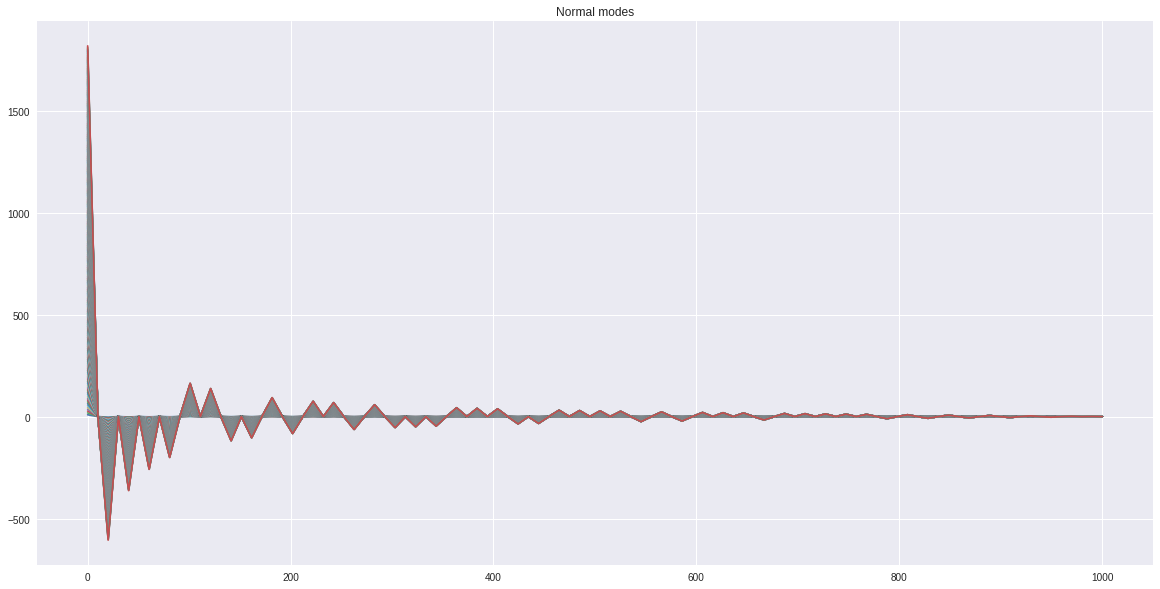

In [11]:
eigenvalues, eigenvectors = eigenstuff(N,L,ta)

In [12]:
# Uncomment this line if you'd like to see the eigenvectors and eigenvalues.
# print(eigenvalues, eigenvectors)

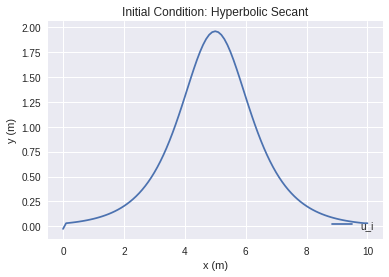

In [29]:
L, N = 10, 100          
b = 1.0                   
h = L/N

t_total = 20
N_t = 200 
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)

A = 0.5
lamb = 2*L
v = b*h/dt
f = v/lamb
k=2*np.pi/lamb

x = np.linspace(0, L, N+1)
u0 = 2.0/np.cosh(x-5)
u1 = 1.0/np.cosh(x-v*dt-5)+1.0/np.cosh(x+v*dt-5)

data = np.zeros((N_t+1,N+1)) 
data[0]=u0
data[1]=u1

for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u0, u1 = u1, u2
    u2[-1] = u2[-2]
    data[i]=u2

data.shape

plt.figure()
plt.title("Initial Condition: Hyperbolic Secant")
plt.plot(x,data[0,:], '-', label='u_i')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(loc='lower right')
plt.show()

Let's disturb the free-ended string in the shape of a right-shifted and stretched hyperbolic secant function and see what happens.

In [30]:
file='hyperbolic-secant-free-end.mp4'
easyanimate_string(ta,data,file)

100%|██████████| 201/201 [00:46<00:00,  4.31it/s]


In [31]:
playVideo(file)

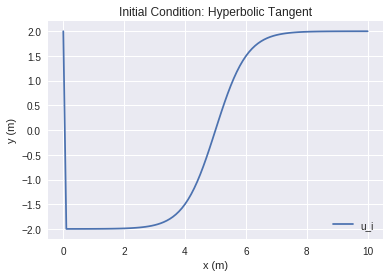

In [32]:
L, N = 10, 100          
b = 1.0                   
h = L/N

t_total = 20
N_t = 200 
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)

A = 0.5
lamb = 2*L
v = b*h/dt
f = v/lamb
k=2*np.pi/lamb

x = np.linspace(0, L, N+1)
u0 = 2*np.tanh(x-5)
u1 = np.tanh(x-v*dt-5)+np.tanh(x+v*dt-5)

data = np.zeros((N_t+1,N+1)) 
data[0]=u0
data[1]=u1

for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u0, u1 = u1, u2
    u2[-1] = u2[-2]
    data[i]=u2

data.shape

plt.figure()
plt.title("Initial Condition: Hyperbolic Tangent")
plt.plot(x,data[0,:], '-', label='u_i')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(loc='lower right')
plt.show()

In [33]:
file='hyperbolic-tangent-free-end.mp4'
easyanimate_string(ta,data,file)

100%|██████████| 201/201 [00:49<00:00,  4.04it/s]


In [34]:
playVideo(file)